In [1]:
!pip install Pillow # used to resize images

In [0]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import time

from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Download the starter CSV

In [0]:
DL_DIR = "/content/gdrive/My Drive/DL_project/"
TRAIN_PATCH_DIR = os.path.join(DL_DIR, "all_patches/training_patches")
training_csv_path = os.path.join(DL_DIR, "all_patches/training_patches.csv")
VALIDATION_PATCH_DIR = os.path.join(DL_DIR, "all_patches/validation_patches")
validation_csv_path = os.path.join(DL_DIR, "all_patches/validation_patches.csv")
TEST_PATCH_DIR = os.path.join(DL_DIR, "all_patches/test_patches")
test_csv_path = os.path.join(DL_DIR, "all_patches/test_patches.csv")

### Sanity check

At this point, you have all the data you need to train your model (questions, answers, and images) in a convenient and easy to read format. 

Now would be a good time for another santity check. Write a block of code to iterate over the starter CSV file. For each image, make sure you can locate it on disk. E.g., 

In [0]:
import pandas as pd
import numpy as np

training_patches = pd.read_csv(training_csv_path, sep=',')
del training_patches["Unnamed: 0"]

validation_patches = pd.read_csv(validation_csv_path, sep=',')
del validation_patches["Unnamed: 0"]

test_patches = pd.read_csv(test_csv_path, sep=',')
del test_patches["Unnamed: 0"]
del test_patches["Unnamed: 0.1"]

In [0]:
# for index, row in training_patches.iterrows():
#     print(row["deepPatch"])
#     assert os.path.exists('/content/gdrive/My Drive/DL_project/all_patches/training_patches/image_1_tumor_1.jpg')
#     assert os.path.exists(row["deepPatch"])
#     break

In [8]:
for index, row in training_patches.iterrows():
    assert os.path.exists(row["deepPatch"])
    assert os.path.exists(row["shallowPatch"])
    assert os.path.exists(row["deepPatch"]+".npy")
print("Training PASS!")

for index, row in validation_patches.iterrows():
    assert os.path.exists(row["deepPatch"])
    assert os.path.exists(row["shallowPatch"])
    assert os.path.exists(row["deepPatch"]+".npy")
print("Validation PASS!")

for index, row in test_patches.iterrows():
    assert os.path.exists(row["deepPatch"])
    assert os.path.exists(row["shallowPatch"])
    assert os.path.exists(row["deepPatch"]+".npy")
print("Test PASS!")

Training PASS!
Validation PASS!
Test PASS!


### Shuffle the dataset and balance.

In [0]:
# Your code here
# Shuffle the starter CSV
# Remove 4,000 rows (or so) and move them to a separate file or data structure

# poses = patches[patches["is_tumor"] == 1]
# negs = patches[patches["is_tumor"] == 0]
# pos_train, pos_test = train_test_split(poses, test_size=1-400/poses.shape[0])
# neg_train, neg_test = train_test_split(negs, test_size=1-400/negs.shape[0])

# already balanced in patch extraction
final_train = training_patches
final_val = validation_patches
final_test = test_patches

In [10]:
final_train.shape, final_val.shape

((2085, 5), (560, 5))

### Verify your train and validation sets look as expected

In [11]:
# Your code here.
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


print("Training set length:", final_train.shape)
print("Training tumor count:", final_train[final_train["is_tumor"]==1].shape[0])
print()

for n in range(4):
  example = final_train.sample()
  deep_path = example["deepPatch"].values[0]
  shallow_path = example["shallowPatch"].values[0]
  is_tumor = example["is_tumor"].values[0]
  if is_tumor:
      print("It is a tumor patch!!!")
  print("Deep patch: %s" % deep_path)
  imgplot = plt.imshow(mpimg.imread(deep_path))
  plt.show()
  print("Shallow patch: %s" % shallow_path)
  imgplot = plt.imshow(mpimg.imread(shallow_path))
  plt.show()
  print()

print("Validating set length:", final_val.shape)
print("Validating tumor count:", final_val[final_val["is_tumor"]==1].shape[0])
print()

for n in range(4):
  example = final_val.sample()
  deep_path = example["deepPatch"].values[0]
  shallow_path = example["shallowPatch"].values[0]
  is_tumor = example["is_tumor"].values[0]
  if is_tumor:
      print("It is a tumor patch!!!")
  print("Deep patch: %s" % deep_path)
  imgplot = plt.imshow(mpimg.imread(deep_path))
  plt.show()
  print("Shallow patch: %s" % shallow_path)
  imgplot = plt.imshow(mpimg.imread(shallow_path))
  plt.show()
  print()

Output hidden; open in https://colab.research.google.com to view.


### Forward your images through InceptionV3, and cache activations to disk

In [0]:
# Create a feature extraction model.
# You should not need to modify this (though you may, if you'd like
# to use a model other than Inception).
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [0]:
# A method to load an image off disk, and extract activations using 
# the model above. You should not need to modify this.
def image_to_activations(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  activations = tf.keras.applications.inception_v3.preprocess_input(img)
  return activations, image_path

In [14]:
# Your code here

# You'll need to extract activations for every image in your train, validation,
# and test set. First, create a set of the absolute paths to all of these images 
# (image_path_set). Populate this with the absolute paths to all these images.
deep_path_set = set()
shallow_path_set = set()
all_dataset = [final_train, final_val, final_test]
for ds in all_dataset:
  for img in ds["deepPatch"].tolist():
    deep_path_set.add(img)
  for img in ds["shallowPatch"].tolist():
    shallow_path_set.add(img)

print("Deep patches to preprocess", len(deep_path_set))
print("Shallow patches to preprocess", len(shallow_path_set))
print("This make take a few minutes")

Deep patches to preprocess 3455
Shallow patches to preprocess 802
This make take a few minutes


#### image to activation for deep scale

In [15]:
# create activation folder
!mkdir /content/gdrive/My\ Drive/DL_project/all_patches/inception_v3_activations/
IC3_ACT_DIR = "/content/gdrive/My Drive/DL_project/all_patches/inception_v3_activations/"

mkdir: cannot create directory ‘/content/gdrive/My Drive/DL_project/all_patches/inception_v3_activations/’: File exists


In [0]:
# # Create a dataset to load each image off disk, and extract activations
# deep_activation_dataset = tf.data.Dataset.from_tensor_slices(list(deep_path_set))
# deep_activation_dataset = deep_activation_dataset.map(
#   image_to_activations, 
#   num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# # Save all activations to disk in NumPy format
# n= 0
# for img_batch, path_batch in deep_activation_dataset:
#   n += 1
#   if n % 10 == 0 and n != 0:
#       print(n)
#   batch_features = image_features_extract_model(img_batch)
#   for bf, p in zip(batch_features, path_batch):
#     path_of_feature = p.numpy().decode("utf-8")
#     path_of_feature = os.path.join(IC3_ACT_DIR, path_of_feature.split('/')[-1])
#     np.save(path_of_feature, bf.numpy())  


#### image to activation for shallow scale

In [0]:
# # Create a dataset to load each image off disk, and extract activations
# shallow_activation_dataset = tf.data.Dataset.from_tensor_slices(list(shallow_path_set))
# shallow_activation_dataset = shallow_activation_dataset.map(
#   image_to_activations, 
#   num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# # Save all activations to disk in NumPy format
# n= 0
# for img_batch, path_batch in shallow_activation_dataset:
#   n += 1
#   if n % 10 == 1 and n != 0:
#       print(n)
#   batch_features = image_features_extract_model(img_batch)
#   for bf, p in zip(batch_features, path_batch):
#     path_of_feature = p.numpy().decode("utf-8")
#     path_of_feature = os.path.join(IC3_ACT_DIR, path_of_feature.split('/')[-1])
#     np.save(path_of_feature, bf.numpy())  


### Create a list for train, validation and test

In [0]:
# Your code here. Populate these for your training set.
deep_train = final_train["deepPatch"].tolist() # a list of absolute paths to images in your training set
shallow_train = final_train["shallowPatch"].tolist() # a list of questions in your training set
tumor_train = final_train["is_tumor"].tolist() # a list of answers (in numeric format) in your training set
patch_loc_train = final_train["patchLoc"].tolist()

# Your code here. Populate these for your validation set.
deep_val = final_val["deepPatch"].tolist() # a list of absolute paths to images in your training set
shallow_val = final_val["shallowPatch"].tolist() # a list of questions in your training set
tumor_val = final_val["is_tumor"].tolist() # a list of answers (in numeric format) in your training set
patch_loc_val = final_val["patchLoc"].tolist()

# # Your code here. Populate these for your test set
deep_test = final_test["deepPatch"].tolist() # a list of absolute paths to images in your training set
shallow_test = final_test["shallowPatch"].tolist() # a list of questions in your training set
tumor_test = final_test["is_tumor"].tolist() # a list of answers (in numeric format) in your training set
patch_loc_test = final_test["patchLoc"].tolist()

### Create a tf.dataset for training, validation, and testing

The method to create the dataset is provided for you, though you will need to get it working by passing the ```padded_train```, ```answers_train``` ```and images_train``` lists you created above.




In [0]:
# You should not need to modify this.
BATCH_SIZE = 32
BUFFER_SIZE = 100

In [0]:
# You should not need to modify this.
# Load cached activations off disk.
def load_np(deep_path, shallow_path, is_tumor, patch_loc):
  deep_activation_path = deep_path.decode("utf-8").split('/')[-1]
  deep_activation_path = os.path.join(IC3_ACT_DIR, deep_activation_path)+'.npy'
  shallow_activation_path = shallow_path.decode("utf-8").split('/')[-1]
  shallow_activation_path = os.path.join(IC3_ACT_DIR, shallow_activation_path)+'.npy'
  tumor_activation_path = deep_path.decode("utf-8")+'.npy'
  deep_activations = np.load(deep_activation_path)
  shallow_activations = np.load(shallow_activation_path)
  tumor_activations = np.load(tumor_activation_path)
  return deep_activations, shallow_activations, tumor_activations, is_tumor, patch_loc

In [0]:
# You should not need to modify this.

# This method will create a dataset that returns four elements.
# - a batch of activations (loaded from disk)
# - a batch of padded questions
# - a batch of numeric answers
# - a batch of absolute paths to the corresponding images
def create_dataset(deep, shallow, tumor, patch_loc, TEST=False, batch_size=BATCH_SIZE):
  dataset = tf.data.Dataset.from_tensor_slices((deep, 
                                                shallow, 
                                                tumor,
                                                patch_loc))
  # TODO jbgordon@: rewrite this to be clearer
  # Load the cached activations off disk
  dataset = dataset.map(lambda x, y, z, d: tf.numpy_function(
      load_np, [x, y, z, d], [tf.float32, tf.float32, tf.float32, tf.float32, tf.string]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  # Shuffle and batchd
  if TEST:
      dataset = dataset.batch(batch_size)
  else:
      dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [0]:
# Your code here

# Call the above method to create train, val, and test datasets.
# If you want to follow along with the starter code, I suggest these
# variable names:

train_ds = create_dataset(deep_train, shallow_train, tumor_train, patch_loc_train)
val_ds = create_dataset(deep_val, shallow_val, tumor_val, patch_loc_val)
test_ds = create_dataset(deep_test, shallow_test, tumor_test, patch_loc_test, True, len(deep_test))

### Sanity check (optional)
That dataset creation method is complicated. Write a block of code that demonstrates how to use the dataset (e.g., retrieve a batch of activations, questions, answeres, and images paths) and verify they look as expected.

In [21]:
# Your code here (optional)
# Verify your datasets are working properly

# Here is code you can use to quickly retrieve a batch of data

my_iterator = iter(train_ds)
deep_activations_batch, shallow_activations_batch, tumor_activation_batch, patch_loc_batch, tumor_batch = next(my_iterator)

print(deep_activations_batch.shape, 
      shallow_activations_batch.shape, 
      tumor_activation_batch.shape,
      tumor_batch.shape, 
      patch_loc_batch.shape)


(32, 8, 8, 2048) (32, 8, 8, 2048) (32, 128, 128) (32,) (32,)


### Define your DEEP-SHALLOW model

You can base your code off the example give toward bottom of this [guide](https://keras.io/getting-started/functional-api-guide/) (but use a smaller model to start). Aim for a couple hundred thousand parameters or so

In [0]:
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from keras import regularizers

In [0]:
# Your code here
# Below is starter code for your model for you to complete.
# See https://keras.io/getting-started/functional-api-guide/ for the idea.
# The vision model is written for you. You will need to write the question
# model.

# Input to your vision model (activations from Inception-V3,
# loaded off disk disk by the dataset above).
deep_input = Input(shape=(8, 8, 2048)) 
deep_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
# deep_model.add(tf.keras.layers.GlobalAveragePooling2D())
# Output of your vision model
encoded_deep = deep_model(deep_input) 

# Your code here
# Write your test processing model that takes the vectorized and padded
# question as input.
# As in the guide above, you will want to produce an `encoded_question`
# as output

shallow_input = Input(shape=(8, 8, 2048)) 
shallow_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
# shallow_model.add(tf.keras.layers.GlobalAveragePooling2D())
# Output of your vision model
encoded_shallow = shallow_model(shallow_input) 

# Concatenate the encoded image and question
merged = tf.keras.layers.concatenate([encoded_deep, encoded_shallow])

# # add a convolutional layer
intermediate1 = Conv2DTranspose(1024, (3, 3), strides=(2, 2), activation='relu',padding='same',
                                kernel_regularizer=regularizers.l2(1e-4),)(merged)
intermediate1 = BatchNormalization()(intermediate1)

intermediate2 = Conv2DTranspose(1024, (3, 3), strides=(2, 2), activation='relu',padding='same',
                                kernel_regularizer=regularizers.l2(1e-4),)(intermediate1)
intermediate2 = BatchNormalization()(intermediate2)
intermediate2 = Dropout(0.1)(intermediate2)

intermediate3 = Conv2DTranspose(256, (5, 5), strides=(2, 2), activation='relu', padding='same',)(intermediate2)
intermediate3 = BatchNormalization()(intermediate3)
intermediate3 = Dropout(0.2)(intermediate3)

intermediate4 = Conv2DTranspose(256, (5, 5), strides=(2, 2), activation='relu', padding='same',)(intermediate3)
intermediate4 = BatchNormalization()(intermediate4)
intermediate4 = Dropout(0.3)(intermediate4)

# # Next, add a binary classifier on top
output = Conv2DTranspose(1, (7, 7),
                         strides=(1, 1),
                         activation='sigmoid',
                         padding='same')(intermediate4)
# output = Dense(128*128, activation="sigmoid")(merged)
# output = Reshape((128,128))(output)

# Your final model
model = Model(inputs=[deep_input, shallow_input], outputs=output)

In [187]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
sequential_30 (Sequential)      (None, 8, 8, 2048)   0           input_32[0][0]                   
__________________________________________________________________________________________________
sequential_31 (Sequential)      (None, 8, 8, 2048)   0           input_33[0][0]                   
___________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Plot your model
Create a schematic that shows the graph of your model, using [plot_model](https://keras.io/visualization/). This can be helpful to ensure the vision and question paths look at expected (it's also super cool, and more informative than .summary).

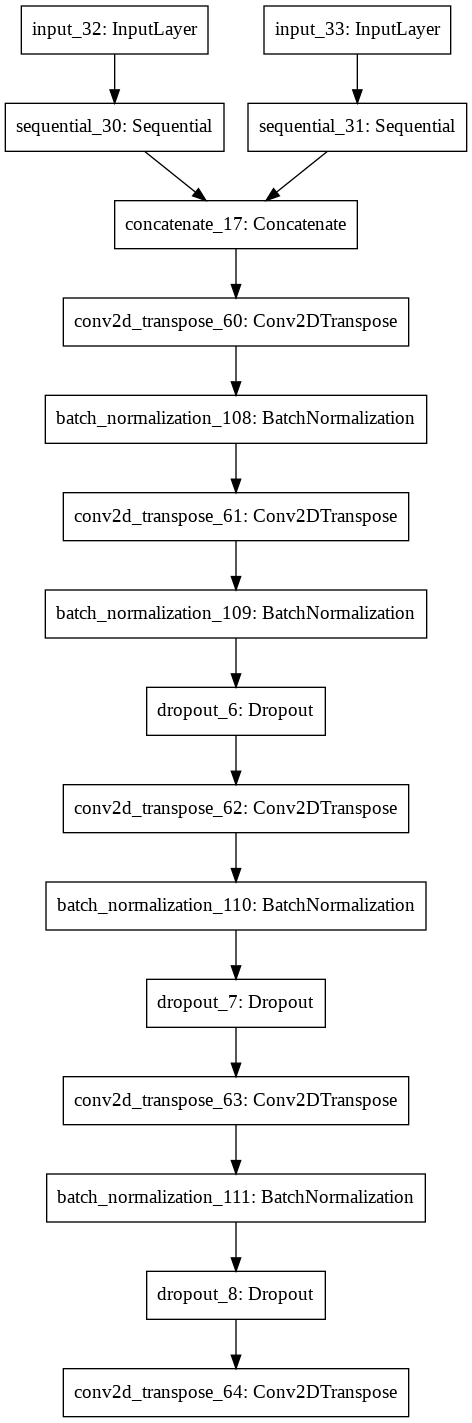

In [189]:
# You should not need to modify this.
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Fit your model on a single batch
Before training on your entire dataset, a helpful first step is to train repeatedly on a single batch, and verify the loss goes to zero. If your model is working properly, it should be able to memorize a batch of data. We will use ```model.train_on_batch``` for this.

In [0]:
# You should not nee to modify this.
# Retrieve a batch of data from your train dataset
deep_activations_batch, shallow_activations_batch, tumor_activations_batch, patch_locs_batch, tumors_batch = next(iter(train_ds))

In [171]:
# Your code here

# Train them model repeatedly using model.train_on_batch
# Verify the loss goes to zero after +/- 100 training steps.
# If it does not, now would be a great time to debug 
# before proceeding further.

# e.g.
# metrics = model.train_on_batch ....
# metrics is a list (loss is metrics[0], accuracy is metrics[1])
for i in range(100):
  metrics = model.train_on_batch(x=[deep_activations_batch, shallow_activations_batch], y=tumor_activations_batch)
  if i % 10 == 0:
    print("loss: " + str(metrics[0]) + " accuracy: " + str(metrics[1]))

loss: 1.2041781 accuracy: 0.49196243
loss: 0.7061775 accuracy: 0.87932205
loss: 0.44025552 accuracy: 0.95072746
loss: 0.33448642 accuracy: 0.9700184
loss: 0.26370254 accuracy: 0.9789696
loss: 0.21743524 accuracy: 0.9823208
loss: 0.1759622 accuracy: 0.9851723
loss: 0.14065881 accuracy: 0.9886112
loss: 0.12063643 accuracy: 0.9877796
loss: 0.09746654 accuracy: 0.99085426


### Use your model to make predictions on the same batch above
Compare the predicted answer to the label. Verify they match.

In [0]:
# You should not need to modify this, but you will want to 
# carefully inspect the output.
for prediction, answer in zip(model.predict(x=[deep_activations_batch, shallow_activations_batch]), tumor_activations_batch):
  prediction = tf.convert_to_tensor(prediction)
  tumor = np.where(answer ==1.0)
  print("tumor_total: %d" % len(tumor[0]))
  tumor_correct = np.where(prediction.numpy()[tumor] > 0.5)
  print("tumor correct: %d" % len(tumor_correct[0]))
  normal = np.where(answer == 0.0)
  print("normal_total: %d" % len(normal[0]))
  normal_correct = np.where(prediction.numpy()[normal] < 0.5)
  print("normal correct: %d" % len(normal_correct[0]))
  print()

### Create a checkpoints directory

In [0]:
# Mount drive
drive_root = '/content/gdrive/My Drive/DL_project'

In [0]:
# If you'd like to save checkpoints in drive, you will need to uncomment
# the code below. Alternatively, you can modify it to save
# checkpoints in Colab (these will not persist if your instance is terminated,
# but you can manually download them if you like).
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "multi_scale_classification")

# Used for formatting
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

In [149]:
# Your code here
# Uncomment this if you'd like to create a checkpoints folder in your drive
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /content/gdrive/My Drive/DL_project/checkpoints/multi_scale_classification
Checkpoints folder already exists


### Restore the latest checkpoint (if it exists).

In [33]:
# You should not need to modify this code.
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from /content/gdrive/My Drive/DL_project/checkpoints/multi_scale_classification/cp-00000009.ckpt


### Metrics

In [0]:
# Utilities to help us record metrics.
# You should not need to modify this code
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

### Code to evaluate on the validation dataset
The validation dataset may be large. It would be wasteful to evaluate on the entire validation dataset each training epoch. Instead, you could evaluate every N epochs, or, you can use the below methoid to evaluate for a fixed number of steps (batches). This will give you a noisier evaluation, but a useful indicator of how your model is doing over time.

In [0]:
# You should not need to modify this.
def evaluate(max_steps=None):
  steps = 0
  normal_correct = 0
  tumor_correct = 0
  tumor_incorrect = 0
  tumor_total = 0
  total = 0
  for deep_activation_batch, shallow_activation_batch, tumor_activation_batch, patch_loc_batch, tumor_batch in val_ds:
    
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=[deep_activation_batch, shallow_activation_batch])
    for i in range(len(predictions)):
      total += 1
      is_tumor = (len(np.where(tumor_activation_batch[i] == 1.0)[0]) != 0)
      if is_tumor:
        tumor_total += 1
        if len(np.where(predictions[i] > 0.5)[0]) != 0:
          tumor_correct += 1
      else:
        if len(np.where(predictions[i] > 0.5)[0]) != 0:
          tumor_incorrect += 1
        else:
          normal_correct += 1
    steps += 1 
    # Record metrics after each batch
    val_loss(tumor_activation_batch, predictions)
    val_accuracy(tumor_activation_batch, predictions)
  recall = tumor_correct / tumor_total
  if recall == 0:
    precision = 0
  else:
    precision = tumor_correct / (tumor_correct + tumor_incorrect)
  accuracy = (tumor_correct + normal_correct) / total
  return (recall, precision, accuracy)

In [181]:
evaluate(1)

(1.0, 0.5, 0.5)

### Train the model
As before, we'll write our training loop using ```train_on_batch```. This is intermediate in complexity between using ```.fit``` and writing everything from scratch using a ```GradientTape```. Because we're not using ```.fit```. Since we're not using .fit, there's a bit of extra code we need to write ourselves to track loss and accuracy as we go.

In [191]:
# Your code here
# Complete this cell (there are only a few parts to write)

# Used to track loss and accuracy as we go
# You should not need to modify these
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []
best_f1_score = 0

epochs = 10 # Your code here
# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for deep_activation_batch, shallow_activation_batch, tumor_activation_batch, patch_loc_batch, tumor_batch in train_ds:
    result = model.train_on_batch(x=[deep_activation_batch, shallow_activation_batch], y=tumor_activation_batch)
    
    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  recall, precision, accuracy = evaluate(max_steps=50)
  if recall > 0:
    f1_score = 2*(recall*precision)/(recall+precision)
  else:
    f1_score = 0
  if f1_score > best_f1_score:
    best_f1_score = f1_score
    # Save a checkpoint after each epoch
    print("Saving weights")
    save_path = checkpoint_path.format(epoch=epoch)
    model.save_weights(save_path)

  # Print progress
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  classification_template = '\tClassification Accuracy: {:.2f}, Tumor Recall {:.2f}, Tumor Precision {:.2f},'
  print(classification_template.format(accuracy, recall, precision))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

Saving weights
Epoch 0, Loss: 0.95, Accuracy: 71.74, Val Loss 0.59, Val Accuracy 75.43, Time: 47.3 secs
	Classification Accuracy: 0.50, Tumor Recall 1.00, Tumor Precision 0.50,
Epoch 1, Loss: 0.72, Accuracy: 80.34, Val Loss 1.11, Val Accuracy 79.89, Time: 40.8 secs
	Classification Accuracy: 0.51, Tumor Recall 0.01, Tumor Precision 1.00,
Saving weights
Epoch 2, Loss: 0.78, Accuracy: 79.58, Val Loss 0.53, Val Accuracy 79.78, Time: 42.9 secs
	Classification Accuracy: 0.63, Tumor Recall 0.90, Tumor Precision 0.58,
Saving weights
Epoch 3, Loss: 0.71, Accuracy: 82.46, Val Loss 0.42, Val Accuracy 82.58, Time: 44.0 secs
	Classification Accuracy: 0.71, Tumor Recall 0.95, Tumor Precision 0.64,
Epoch 4, Loss: 0.69, Accuracy: 83.42, Val Loss 0.54, Val Accuracy 79.84, Time: 40.6 secs
	Classification Accuracy: 0.64, Tumor Recall 0.69, Tumor Precision 0.62,
Epoch 5, Loss: 0.65, Accuracy: 84.05, Val Loss 0.50, Val Accuracy 80.27, Time: 40.2 secs
	Classification Accuracy: 0.66, Tumor Recall 0.40, Tumor

### Create plots of your training and validation loss and accuracy

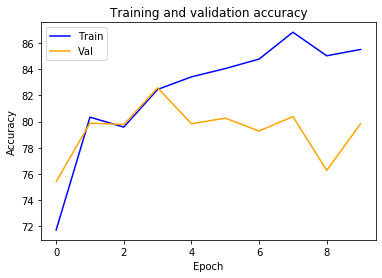

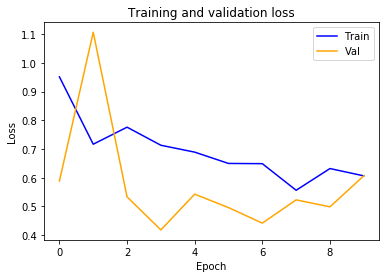

In [192]:
# Your code here
# A plotting function you can reuse
def plot(tlh, tah, vlh, vah):
  
  # The history object contains results on the training and test
  # sets for each epoch
  # acc = 
  # val_acc = history['val_accuracy']
  # loss = history['loss']
  # val_loss = history['val_loss']

  # Get the number of epochs
  epochs = range(len(tah))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, tah, color='blue', label='Train')
  plt.plot(epochs, vah, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, tlh, color='blue', label='Train')
  plt.plot(epochs, vlh, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

### load the model with best f1_score

In [196]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from /content/gdrive/My Drive/DL_project/checkpoints/multi_scale_classification/cp-00000003.ckpt


## Test an image with the model

In [197]:
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
def test_evaluate(max_steps=None):
  steps = 0
  normal_correct = 0
  tumor_correct = 0
  tumor_incorrect = 0
  tumor_total = 0
  total = 0
  for deep_activation_batch, shallow_activation_batch, tumor_activation_batch, patch_loc_batch, tumor_batch in test_ds:
    
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=[deep_activation_batch, shallow_activation_batch])
    for i in range(len(predictions)):
      total += 1
      is_tumor = (len(np.where(tumor_activation_batch[i] == 1.0)[0]) != 0)
      if is_tumor:
        tumor_total += 1
        if len(np.where(predictions[i] > 0.5)[0]) != 0:
          tumor_correct += 1
      else:
        if len(np.where(predictions[i] > 0.5)[0]) != 0:
          tumor_incorrect += 1
        else:
          normal_correct += 1
    steps += 1 
    # Record metrics after each batch
    test_accuracy(tumor_activation_batch, predictions)
  recall = tumor_correct / tumor_total
  if recall == 0:
    precision = 0
  else:
    precision = tumor_correct / (tumor_correct + tumor_incorrect)
  accuracy = (tumor_correct + normal_correct) / total
  return (recall, precision, accuracy)
results = test_evaluate(1)
classification_template = '\tClassification Accuracy: {:.2f}, Tumor Recall {:.2f}, Tumor Precision {:.2f},'
print(classification_template.format(accuracy, recall, precision))

	Classification Accuracy: 0.96, Tumor Recall 0.00, Tumor Precision 0.00,


## plot the heatmap for test image tumor_091.tif

In [0]:
hl = list()
for i in range(int(predictions.shape[0]/30)):
  hl.append(np.hstack(list(predictions[i*30:(i+1)*30])))
heatmap = np.vstack(hl).squeeze(2)

In [0]:
heatmap *= (255.0/heatmap.max())

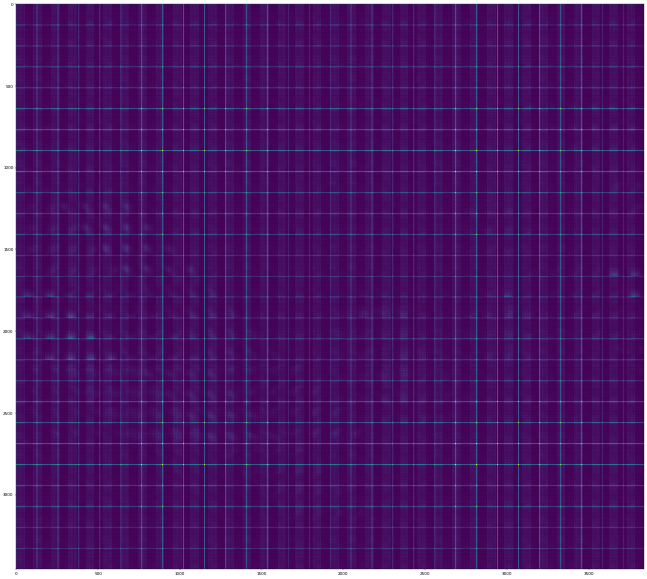

In [206]:
plt.figure(figsize=(27,30), dpi=30)
plt.imshow(heatmap)